# Evaluate trained policies at checkpoints

In [1]:
from gymnasium.experimental.wrappers import RecordVideoV0
from orbax.checkpoint import PyTreeCheckpointer

import _pickle as pickle
import jax
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import timeit

from jaxl.buffers import get_buffer
from jaxl.constants import *
from jaxl.models import (
    get_model,
    get_policy,
    policy_output_dim,
)
from jaxl.models.policies import MultitaskPolicy
from jaxl.envs import get_environment
from jaxl.envs.rollouts import EvaluationRollout
from jaxl.utils import set_seed, parse_dict, set_dict_value, get_dict_value

In [2]:
run_seed = None
set_seed(run_seed)

In [3]:
def get_env(agent_path):
    agent_config_path = os.path.join(agent_path, "config.json")
    with open(agent_config_path, "r") as f:
        agent_config_dict = json.load(f)
    return agent_config_dict["learner_config"]["env_config"]

In [4]:
agent_path = "/Users/chanb/research/personal/jaxl/jaxl/logs/inverted_double_pendulum/ppo-discrete_control/07-10-23_12_51_45-7a5cb2db-a906-444e-87df-b4a67bb523cd"
trained_env_parameters = get_env(agent_path)

num_episodes = 100
env_seed = 9999
buffer_size = 0
record_video = True
load_termination = True

In [5]:
def get_config(agent_path):
    agent_config_path = os.path.join(agent_path, "config.json")
    with open(agent_config_path, "r") as f:
        agent_config_dict = json.load(f)
        agent_config_dict["learner_config"]["env_config"] = trained_env_parameters
        agent_config_dict["learner_config"]["env_config"]["env_kwargs"][
            "render_mode"
        ] = "rgb_array"
        if "policy_distribution" not in agent_config_dict["learner_config"]:
            agent_config_dict["learner_config"][
                "policy_distribution"
            ] = CONST_DETERMINISTIC
        set_dict_value(agent_config_dict, "vmap_all", False)
        (multitask, num_models) = get_dict_value(agent_config_dict, "num_models")
        agent_config = parse_dict(agent_config_dict)
    return agent_config, {
        "multitask": multitask,
        "num_models": num_models,
    }

In [6]:
episodic_returns_per_variant = {}
if load_termination:
    checkpoint_paths = [os.path.join(agent_path, "termination_model")]
else:
    checkpoint_paths = os.listdir(os.path.join(agent_path, "models"))

for checkpoint_path in checkpoint_paths:
    agent_config, aux = get_config(agent_path)
    env = get_environment(agent_config.learner_config.env_config)

    model_id = "final" if load_termination else int(checkpoint_path.split("-")[-1])
    if record_video:
        env = RecordVideoV0(env, f"videos/model_id_{model_id}-videos")

    input_dim = env.observation_space.shape
    output_dim = policy_output_dim(env.act_dim, agent_config.learner_config)
    model = get_model(
        input_dim,
        output_dim,
        getattr(agent_config.model_config, "policy", agent_config.model_config),
    )
    policy = get_policy(model, agent_config.learner_config)
    if aux["multitask"]:
        policy = MultitaskPolicy(policy, model, aux["num_models"])

    agent_model_path = (
        checkpoint_path
        if load_termination
        else os.path.join(agent_path, "models", checkpoint_path)
    )
    checkpointer = PyTreeCheckpointer()
    model_dict = checkpointer.restore(agent_model_path)
    agent_policy_params = model_dict[CONST_MODEL][CONST_POLICY]
    with open(os.path.join(agent_model_path, "learner_dict.pkl"), "rb") as f:
        learner_dict = pickle.load(f)
        agent_obs_rms = learner_dict[CONST_OBS_RMS]

    agent_rollout = EvaluationRollout(env, seed=env_seed)
    agent_rollout.rollout(
        agent_policy_params, policy, agent_obs_rms, num_episodes, None
    )

    episodic_returns_per_variant[model_id] = agent_rollout.episodic_returns

  1%|          | 1/100 [00:00<00:54,  1.80it/s]

Moviepy - Building video /Users/chanb/research/personal/jaxl/notebooks/model_id_final-videos/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/chanb/research/personal/jaxl/notebooks/model_id_final-videos/rl-video-episode-0.mp4



  2%|▏         | 2/100 [00:01<00:57,  1.69it/s]

Moviepy - Done !
Moviepy - video ready /Users/chanb/research/personal/jaxl/notebooks/model_id_final-videos/rl-video-episode-0.mp4
Moviepy - Building video /Users/chanb/research/personal/jaxl/notebooks/model_id_final-videos/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/chanb/research/personal/jaxl/notebooks/model_id_final-videos/rl-video-episode-1.mp4



  8%|▊         | 8/100 [00:01<00:11,  8.27it/s]

Moviepy - Done !
Moviepy - video ready /Users/chanb/research/personal/jaxl/notebooks/model_id_final-videos/rl-video-episode-1.mp4


  8%|▊         | 8/100 [00:01<00:11,  8.27it/s]

Moviepy - Building video /Users/chanb/research/personal/jaxl/notebooks/model_id_final-videos/rl-video-episode-8.mp4.
Moviepy - Writing video /Users/chanb/research/personal/jaxl/notebooks/model_id_final-videos/rl-video-episode-8.mp4



 10%|█         | 10/100 [00:01<00:11,  7.97it/s]

Moviepy - Done !
Moviepy - video ready /Users/chanb/research/personal/jaxl/notebooks/model_id_final-videos/rl-video-episode-8.mp4


 24%|██▍       | 24/100 [00:02<00:03, 25.29it/s]

Moviepy - Building video /Users/chanb/research/personal/jaxl/notebooks/model_id_final-videos/rl-video-episode-27.mp4.
Moviepy - Writing video /Users/chanb/research/personal/jaxl/notebooks/model_id_final-videos/rl-video-episode-27.mp4



 29%|██▉       | 29/100 [00:02<00:03, 21.91it/s]

Moviepy - Done !
Moviepy - video ready /Users/chanb/research/personal/jaxl/notebooks/model_id_final-videos/rl-video-episode-27.mp4


 62%|██████▏   | 62/100 [00:02<00:00, 53.65it/s]

Moviepy - Building video /Users/chanb/research/personal/jaxl/notebooks/model_id_final-videos/rl-video-episode-64.mp4.
Moviepy - Writing video /Users/chanb/research/personal/jaxl/notebooks/model_id_final-videos/rl-video-episode-64.mp4



 62%|██████▏   | 62/100 [00:03<00:00, 53.65it/s]

Moviepy - Done !
Moviepy - video ready /Users/chanb/research/personal/jaxl/notebooks/model_id_final-videos/rl-video-episode-64.mp4


100%|██████████| 100/100 [00:03<00:00, 26.72it/s]


In [7]:
from pprint import pprint

pprint(
    [
        (key, np.mean(val), np.std(val))
        for key, val in episodic_returns_per_variant.items()
    ]
)

[('final', 234.94415072308817, 95.27074809331478)]


/var/folders/h6/qs8bwp4d7bg67j4vbv960hdh0000gn/T/ipykernel_66365/3652737342.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


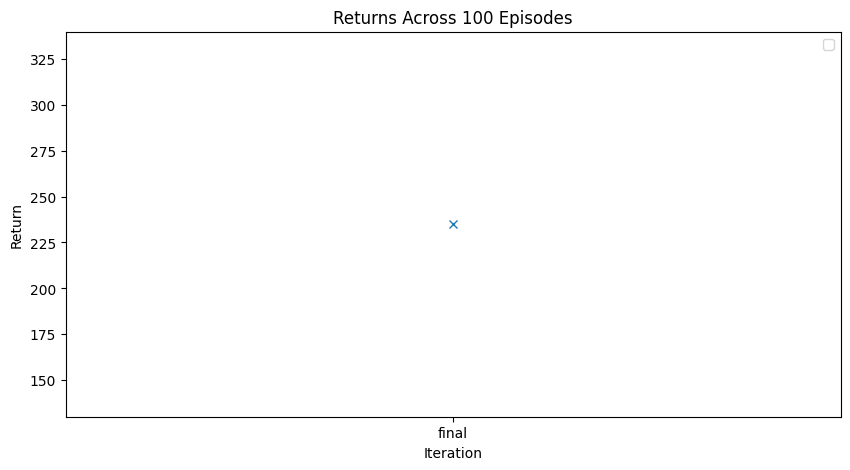

In [8]:
fig, ax = plt.subplots(1, figsize=(10, 5))

model_ids = list(episodic_returns_per_variant.keys())
means = []
stds = []
for val in episodic_returns_per_variant.values():
    means.append(np.mean(val))
    stds.append(np.std(val))
means = np.array(means)
stds = np.array(stds)

sort_idxes = np.argsort(model_ids)
model_ids = np.array(model_ids)
ax.plot(model_ids[sort_idxes], means[sort_idxes], marker="x")
ax.fill_between(
    model_ids[sort_idxes],
    means[sort_idxes] + stds[sort_idxes],
    means[sort_idxes] - stds[sort_idxes],
    alpha=0.1,
)
ax.set_title(f"Returns Across {num_episodes} Episodes")
ax.set_xlabel("Iteration")
ax.set_ylabel("Return")
ax.legend()
fig.show()